# SSD PyTorch Demonstration

## Import module
First of all, import necessary modules and set hardware device.

In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
print("PyTorch version: " + str(torch.__version__))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.__str__() + ": " + torch.version.cuda + " available")

PyTorch version: 0.4.0
cuda: 9.0.176 available


## VOC dataset

### Declare the parameter set for data loading
One example is provided for the reader. Those parameters can be rewritten for initialization.

In [3]:
from voc2007_12 import VOCDataBase
from augmentation import *

dataset_parameter = {
    'root' : None, 'image_set' : "trainval", 'years' : None,
    'transforms' : None, 'keep_difficult' : False
}
dataset_parameter['transforms'] = Compose([ConvertToNumPyFloat(), RandomCrop(300, th=0.3),
                                           RandomHorizontalFlip(), NormalizeBoundingBox(), 
                                           Resize(300), PhotometricDistort(),
                                           SubstractData([104, 117, 123])])
dataset_parameter['root'] = "/home/sanyu/Desktop/dl4cv/VOCdevkit"
dataset_parameter['years'] = ["2007"]
print(dataset_parameter['transforms'])

Compose(
    ConvertToNumPyFloat()
    RandomCrop(size=(300, 300), p=0.5, th=0.3)
    RandomHorizontalFlip(p=0.5)
    NormalizeBoundingBox()
    Resize(size=(300, 300))
    PhotometricDistort(
    RandomContrast(lower=0.5, upper=1.5, p=0.5)
    ConvertColorFormat(current=BGR, transform=HSV)
    RandomSaturation(lower=0.5, upper=1.5, p=0.5)
    RandomHue(delta=18.0, p=0.5)
    ConvertColorFormat(current=HSV, transform=BGR)
    RandomContrast(lower=0.5, upper=1.5, p=0.5)
)
    SubstractData(mean=[104, 117, 123])
)


### Initialize data class
The function, collate, specifies how data packed for the dataloader with batch size. The reader can move it away. 

(array([[[ -42.476368 ,  -96.66317  , -121.476364 ],
         [ -19.476372 ,  -73.7225   , -101.476364 ],
         [ -23.476372 ,  -78.86097  , -112.47637  ],
         ...,
         [ 136.12804  ,  106.523636 ,  120.523636 ],
         [ 115.910446 ,   87.523636 ,  112.523636 ],
         [ 114.02913  ,   87.523636 ,  106.523636 ]],
 
        [[ -56.476368 , -107.48515  , -126.476364 ],
         [ -34.47637  ,  -82.46538  , -103.47637  ],
         [ -22.476372 ,  -71.62361  ,  -99.47637  ],
         ...,
         [  90.523636 ,   56.523636 ,   64.939026 ],
         [ 133.08847  ,   99.523636 ,  115.523636 ],
         [ 114.523636 ,   81.523636 ,   94.919235 ]],
 
        [[ -41.476368 ,  -81.04999  ,  -89.476364 ],
         [ -53.476368 ,  -93.01043  ,  -99.476364 ],
         [ -54.476368 ,  -94.16867  , -108.476364 ],
         ...,
         [ -61.476368 , -103.287346 , -121.476364 ],
         [  90.523636 ,   49.523636 ,   47.077484 ],
         [ 139.52364  ,  108.523636 ,  108.879684 ]

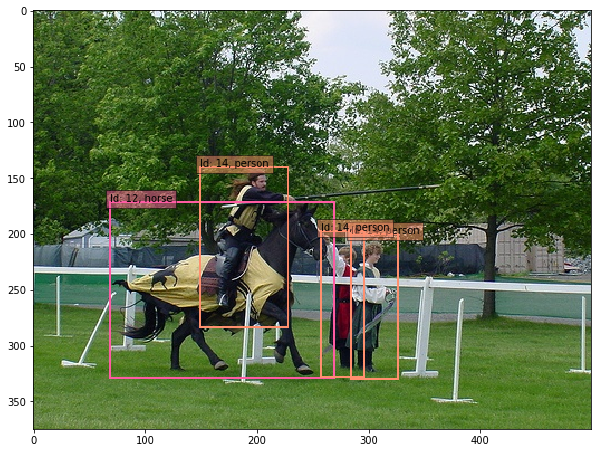

In [5]:
 def collate(batch):
    """Customized collate function for detection-oriented applications.The packed/return is expected 
       by the iterator of training, and the iterator of unpacked/argument here depends on VOCDataBase.__getitem__.
    Arguments:
      batch: (tuple) A tuple of tensor images and lists of annotations.
    Return:
        1) a stack of frames: (tensor), sized [#batch,3, 300, 300].     
        2) gt_boxes:  (list) annotations for a given image, length: #batch
        3) gt_labels: (list) annotations for a given image, length: #batch
    """
    gt_boxes = []
    frames = []
    gt_labels = []
    for image, boxes, labels in batch:
        gt_labels.append(labels)
        frames.append(image)
        gt_boxes.append(boxes)
    return torch.stack(frames, 0), (gt_boxes, gt_labels)

train_data = VOCDataBase(dataset_parameter)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False, collate_fn = collate, num_workers=1)
train_data.showGroundTruth(2)
train_data[2]

[12, 14, 14, 14]
[[[ 36  52  42]
  [ 28  43  37]
  [ 22  35  29]
  ...
  [ 30  38  29]
  [ 64  64  58]
  [119 119 111]]

 [[ 31  50  39]
  [ 29  47  39]
  [ 77  91  82]
  ...
  [ 49  54  47]
  [109 109 102]
  [ 73  74  64]]

 [[ 33  53  42]
  [ 28  50  38]
  [ 47  64  51]
  ...
  [100 100  96]
  [ 44  45  37]
  [ 50  51  40]]

 ...

 [[ 41  68  56]
  [ 42  71  58]
  [ 38  65  53]
  ...
  [ 32  66  51]
  [ 36  71  54]
  [ 33  67  51]]

 [[ 39  70  56]
  [ 39  71  57]
  [ 42  72  59]
  ...
  [ 37  70  55]
  [ 34  66  50]
  [ 36  68  52]]

 [[ 31  64  49]
  [ 31  65  49]
  [ 27  59  45]
  ...
  [ 39  73  58]
  [ 33  63  49]
  [ 38  68  54]]]


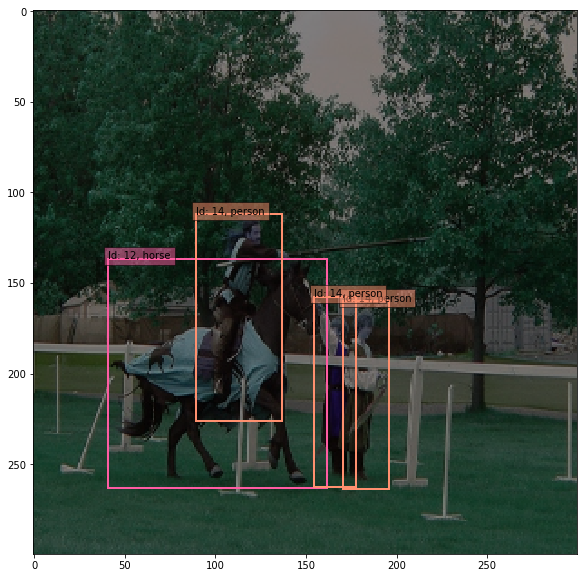

In [10]:
from config import *
img, gt_box, gt_id = train_data[2]
img += [104, 117, 123]
img = img.astype(np.uint8)
print(gt_id)
print(img)
plt.figure(figsize=(10, 10))
colors = plt.cm.gnuplot2(np.linspace(0, 1, 21)).tolist()
plt.imshow(img)
currentAxis = plt.gca()
        
for box, id_ in zip(gt_box, gt_id):
    x_min = box[0] * 300
    y_min = box[1] * 300
    width = box[2] * 300 - x_min 
    height = box[3] * 300 - y_min 
    color = colors[id_]
    display_txt = 'Id: %d, %s'%(id_, VOC_CLASSES_ID_TO_LABEL[int(id_)])
    currentAxis.add_patch(plt.Rectangle([x_min, y_min], width, height, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(x_min, y_min, display_txt, bbox={'facecolor':color, 'alpha':0.5})

## Training

### Load VGG pretraining 
Load the vgg model from the refernce[1] of github page. Then, again the parameter set is for the training configuration.

In [ ]:
from ssd import SSD
model_local_path = '/home/sanyu/Desktop/dl4cv/ssd/weights/vgg16_reducedfc.pth'
pre_train_vgg = torch.load(model_local_path)
model = SSD(pre_train_vgg)

train_parameter = {
    'n_epoch' : 9, 'learning_rate' : 1e-4, 'weight_decay' : 5e-4, 'momentum' : 0.9,
    'milestones' : None, 'gamma' : 0.1, 'device' : None
}
train_parameter['device'] = device

### Training 
Training on the device

In [ ]:
from train import Trainer

loss_total, loss_conf_out, loss_loc_out = [], [], []
train = Trainer(train_parameter, model)
train.train(loss_total, loss_conf_out, loss_loc_out, train_loader)

### Plot losses

In [ ]:
plt.plot(loss_total)
plt.plot(loss_conf_out)
plt.plot(loss_loc_out)

## Evaluation
### Initialize evaluation data/loader

In [ ]:
from voc2007_12 import VOCDataBase

dataset_parameter = {
    'root' : None, 'image_set' : "trainval", 'year' : None,
    'transforms' : None, 'keep_difficult' : False, 'mean' : [104., 117., 123.]
}
dataset_parameter['train_transforms'] = transforms.Compose([transforms.ToTensor()])
dataset_parameter['root'] = "./VOCdevkit"
dataset_parameter['year'] = "2007"
dataset_parameter['image_set'] = "test"

In [ ]:
eval_data = VOCDataBase(dataset_parameter)
eval_loader = torch.utils.data.DataLoader(eval_data, batch_size=1, shuffle=False, collate_fn = detection_collate, num_workers=1)

### Eval

In [ ]:
from eval import Evaluation

eval_parameter = {'device' : None }
eval_parameter['device'] = device
eval_ = Evaluation(eval_parameter, model)
eval_.evaluate(model, eval_loader)